# Predict volume from LiDAR features

In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.callback.progress import ShowGraphCallback

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.interpretation import *
from enveco.model.ensemble import *
from enveco.metrics import *

Run the example workflow for predicting the volume of the field plot from LiDAR-derived features.

# Read and preprocess data

In [3]:
#data_path = Path('../../../andras/ml/AV_leafon/')
data_path = Path('../../enveco_data/enveco/')
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv', 
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

Preprocess dataframes and extract lidar features from them. Specify which features are needed:

* height_features
* point_features
* intensity_features
* height_quantiles
* point_proportions
* canopy_densities

Also, specify whether to `normalize` data (default: True) or to log-transform target column (default: False)

In [4]:
def tree_pcts(row):
    return [row.v_ma/row.v, row.v_ku/row.v, row.v_lp/row.v]

In [5]:
preprocessor.train_val_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.train_val_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [6]:
preprocessor.test_df[['rel_v_ma', 'rel_v_ku', 'rel_v_lp']] = preprocessor.test_df.apply(lambda row: tree_pcts(row), 
                                                                                                  axis=1, result_type='expand')

In [7]:
preprocessor.train_val_df.head()

,sampleplotid,x,y,measurementdate,g,d,h,v,v_ma,v_ku,...,a_date_1,a_window_1,filename_2,a_date_2,a_window_2,v_lp_proc,is_valid,rel_v_ma,rel_v_ku,rel_v_lp
0,901034,313598.50,6888193.46,2013,30.0,25.9,23.9,336.62,50.11,27.73,...,2013-07-11,C,NaN,NaN,NaN,77,0,0.148862,0.082378,0.768760
1,901038,314591.78,6888461.84,2013,18.6,16.0,15.9,146.00,142.50,0.00,...,2013-07-11,C,NaN,NaN,NaN,2,0,0.976027,0.000000,0.023973
2,901044,317890.37,6888182.49,2013,26.8,18.4,18.4,240.46,139.89,81.77,...,2013-07-11,C,NaN,NaN,NaN,8,0,0.581760,0.340057,0.078142
3,901048,318879.42,6888447.55,2013,34.3,20.2,19.3,321.29,72.10,172.35,...,2013-07-11,C,NaN,NaN,NaN,24,0,0.224408,0.536431,0.239161
4,901054,322193.41,6888196.04,2013,13.8,10.0,9.1,67.10,57.40,9.70,...,2013-07-11,C,NaN,NaN,NaN,0,0,0.855440,0.144560,0.000000


In [ ]:
trainval_tb, test_tb = preprocessor.preprocess(target_col=['v_lp'], 
                                               path=data_path,
                                               lidar_pref='AV_las',
                                               image_pref='AV_tif',
                                               mask_plot=False,
                                               min_h=1.3,
                                               normalize=True,
                                               log_y=False,
                                               save_path='../../enveco_data')

Previous method returns two `TabularPandas` objects. Put them to dataloaders.

In [55]:
trainval_tb, test_tb = preprocessor.load_las_image(path='../../enveco_data', target_col=['rel_v_ma', 'rel_v_ku','rel_v_lp'], log_y=False)

In [56]:
dls = trainval_tb.dataloaders(bs=64, y_block=RegressionBlock)

Check the distribution of the target variable `v`, in order to get limits for `sigmoid_range`.

In [57]:
trainval_tb.train.y.describe()

count    1044.000000
mean        0.660042
std         0.353559
min         0.000000
25%         0.385611
50%         0.811735
75%         0.970752
max         1.000000
Name: rel_v_ma, dtype: float64

In [58]:
trainval_tb.valid.y.describe()

count    225.000000
mean       0.691076
std        0.340402
min        0.000000
25%        0.453343
50%        0.828662
75%        0.981815
max        1.000000
Name: rel_v_ma, dtype: float64

In [59]:
test_tb.train.y.describe()

count    225.000000
mean       0.696163
std        0.322651
min        0.000000
25%        0.496747
50%        0.826850
75%        0.961572
max        1.000000
Name: rel_v_ma, dtype: float64

# ANN

Create `Learner` object. Specify y_range to better control the training, set 1000 m³ as the maximum value for the total volume.

Loss function is Mean Squared Error, monitor also Root Mean Squared Error, mean-normalized RMSE, Mean Absolute Error, R2Score, bias and mean-scaled bias. Target variable is log-transformed, so all metrics are log-equivalents (so MSLE, RMSLE...).

In [60]:
learn = tabular_learner(dls, 
                        metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()],  
                        y_range=(0, trainval_tb.train.y.max()*1.1)
                       )
learn.summary()

TabularModel (Input shape: 64 x torch.Size([64, 166]))
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 166            
BatchNorm1d                               332        True      
BatchNorm1d                               332        True      
____________________________________________________________________________
                     64 x 200            
Linear                                    33200      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     64 x 100            
Linear                                    20000      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 3              
Linear                            

Find learning rate to use.

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0030199517495930195)

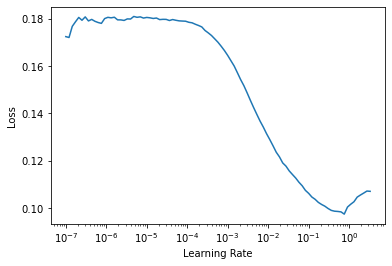

In [61]:
learn.lr_find()

1e-2 seems to be a good learning rate.

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.173061,0.167667,0.409472,122.841438,0.204111,61.233223,0.381813,-0.207538,00:00
1,0.162005,0.146601,0.382886,114.865540,0.187651,56.295059,0.356470,-0.055821,00:00
2,0.146535,0.111734,0.334266,100.279594,0.155486,46.645634,0.308922,0.195296,00:00
3,0.126506,0.077228,0.277899,83.369514,0.116618,34.985207,0.251034,0.443807,00:00
4,0.105557,0.050032,0.223679,67.103592,0.077248,23.174397,0.192025,0.639668,00:00
5,0.085796,0.035598,0.188674,56.602184,0.048771,14.631319,0.152330,0.743624,00:00
6,0.070044,0.028566,0.169016,50.704567,0.034500,10.349870,0.130768,0.794266,00:00
7,0.057782,0.025465,0.159577,47.872955,0.025647,7.694221,0.117925,0.816603,00:00
8,0.048549,0.023638,0.153748,46.124294,0.018614,5.584067,0.111388,0.829756,00:00
9,0.041571,0.023230,0.152413,45.723957,0.014728,4.418282,0.109182,0.832699,00:00


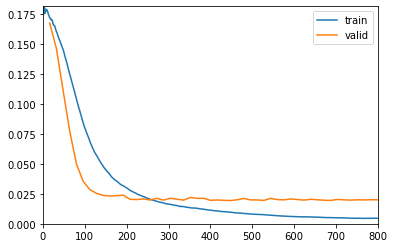

In [62]:
learn.fit_one_cycle(50, lr_max=1e-3, cbs=ShowGraphCallback())

See validation results

In [63]:
learn.validate()

(#7) [0.02003113180398941,0.14153137803077698,42.4593391418457,0.0024843309074640274,0.7452979683876038,0.09310677647590637,0.8557361466028537]

In [64]:
preds, true = learn.get_preds()

`RegressionInterpretation` can be used to plot results.

In [65]:
reg_interp = RegressionInterpretation.from_learner(learn)

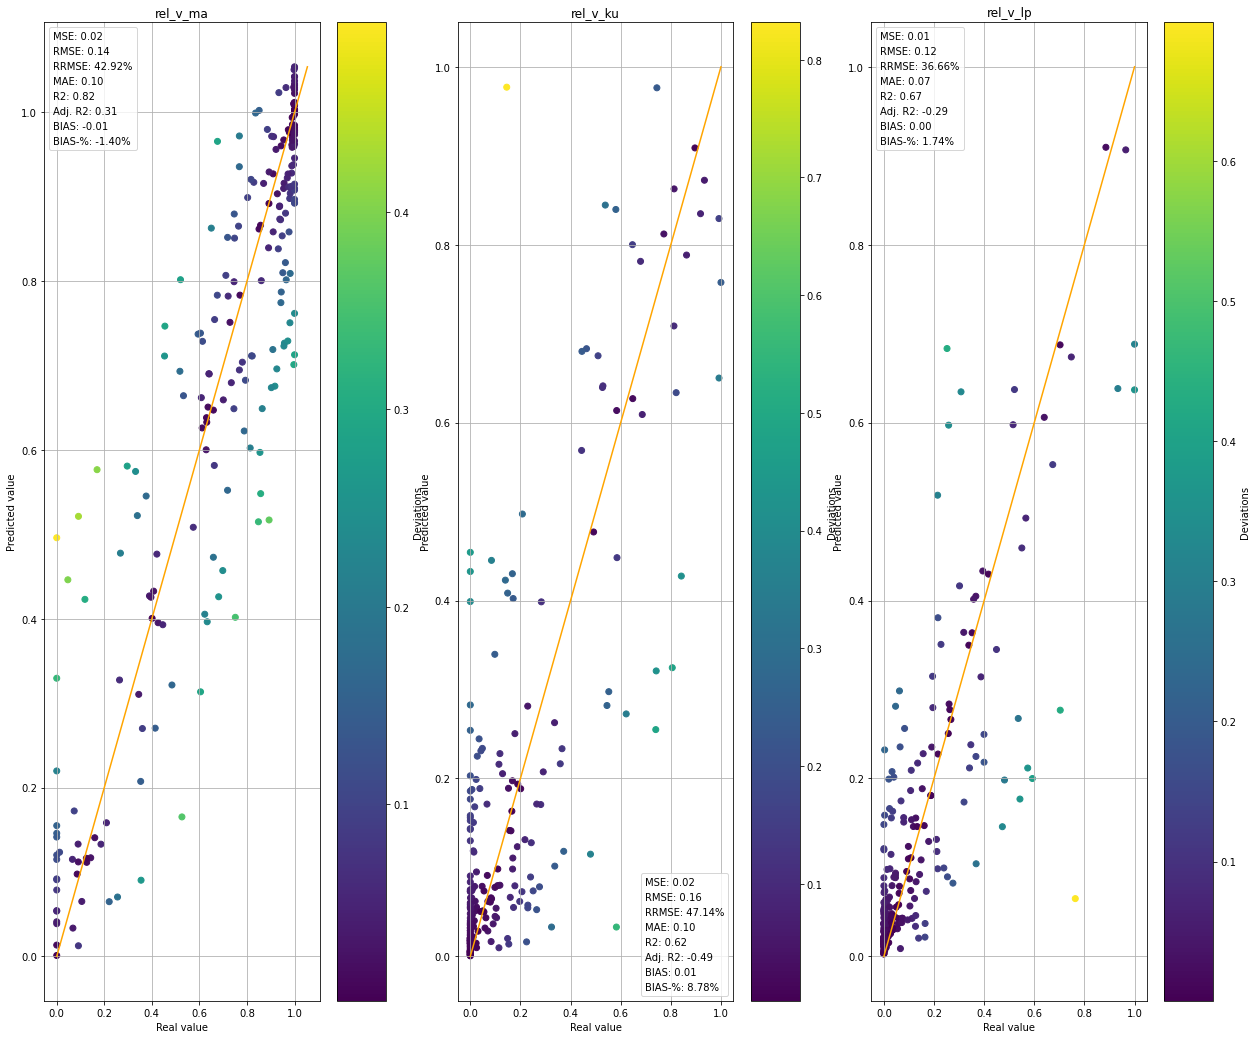

In [66]:
reg_interp.plot_results(log_y=False)
plt.show()

Evaluate test set.

In [67]:
test_dls = test_tb.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False)

In [68]:
test_interp = RegressionInterpretation.from_learner(learn, dl=test_dls.train, ds_idx=0)

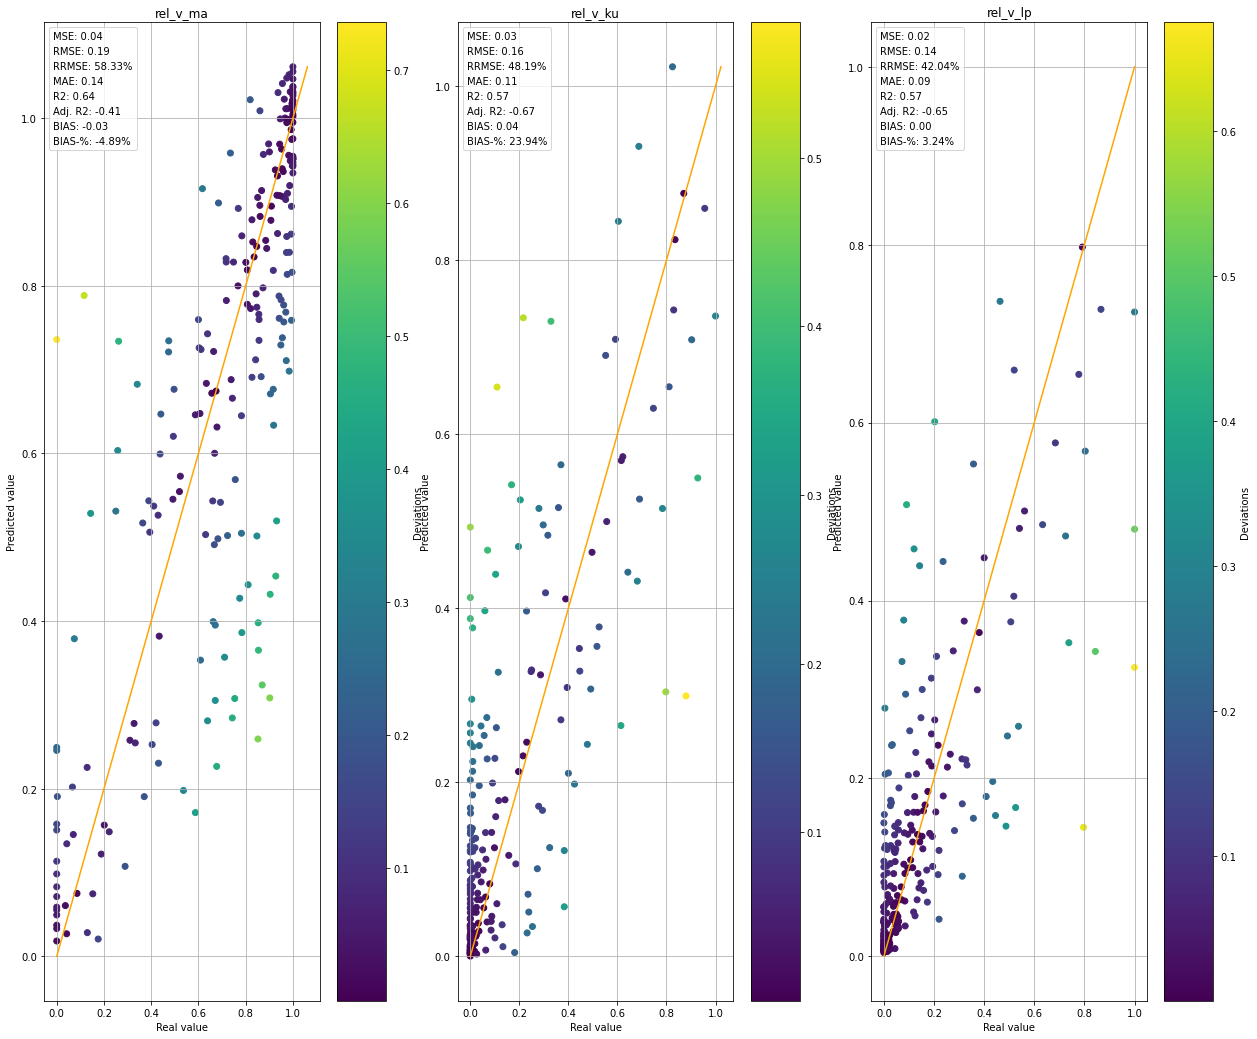

In [69]:
test_interp.plot_results(log_y=False)
plt.show()

In [70]:
test_preds = learn.get_preds(dl=test_dls.train)

In [72]:
tot_v = test_preds[0].sum(axis=-1)

In [76]:
tot_v.max()

tensor(1.1752)

# Ensemble of ANNs

Fit several models at once.

In [77]:
ensemble = Ensemble(dls, learn_func=tabular_learner, ens_dir='ensembles',
                    y_range=(0,1),#trainval_tb.y.max() * 1.1), 
                    metrics=[rmse, rrmse, bias, bias_pct, mae, R2Score()], 
                    n_models=10)

In [78]:
ensemble.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.130348,0.093195,0.305278,91.583328,0.113822,34.146397,0.281979,0.328812,00:00
1,0.080212,0.026351,0.162331,48.699303,-0.006079,-1.823691,0.105948,0.810217,00:00
2,0.059017,0.029367,0.171368,51.410229,-0.003416,-1.024852,0.108452,0.788500,00:00
3,0.048192,0.029577,0.171980,51.594055,-0.007727,-2.317987,0.105802,0.786985,00:00
4,0.041043,0.026266,0.162068,48.620365,0.005112,1.533738,0.098577,0.810832,00:00
5,0.035528,0.027509,0.165859,49.757633,-0.001070,-0.320871,0.103848,0.801879,00:00
6,0.031293,0.027526,0.165909,49.772690,-0.006216,-1.864857,0.099844,0.801759,00:00
7,0.028855,0.023601,0.153628,46.088226,-0.018836,-5.650677,0.094510,0.830023,00:00
8,0.026151,0.023167,0.152207,45.662121,-0.006786,-2.035860,0.092451,0.833151,00:00
9,0.023649,0.024336,0.156001,46.800266,0.001399,0.419574,0.097363,0.824730,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.117852,0.082281,0.286846,86.053696,0.115331,34.599163,0.262924,0.407416,00:00
1,0.073722,0.028536,0.168926,50.677727,-0.005619,-1.685685,0.106730,0.794484,00:00
2,0.054094,0.030030,0.173291,51.987225,-0.007465,-2.239460,0.106955,0.783726,00:00
3,0.043879,0.028519,0.168875,50.662262,-0.010893,-3.268021,0.103613,0.794610,00:00
4,0.037747,0.024251,0.155729,46.718521,0.000698,0.209410,0.098170,0.825342,00:00
5,0.033479,0.024306,0.155904,46.771217,0.005253,1.575783,0.095545,0.824947,00:00
6,0.029578,0.022254,0.149177,44.752945,-0.002667,-0.800180,0.092241,0.839729,00:00
7,0.026900,0.028189,0.167897,50.369061,-0.000164,-0.049276,0.105018,0.796980,00:00
8,0.024429,0.024473,0.156437,46.931122,-0.006267,-1.880127,0.096440,0.823748,00:00
9,0.022282,0.024475,0.156444,46.933071,-0.000783,-0.234868,0.095971,0.823734,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.128660,0.093779,0.306233,91.869820,0.124337,37.301163,0.281790,0.324607,00:00
1,0.080679,0.027399,0.165526,49.657719,-0.008096,-2.428738,0.106847,0.802674,00:00
2,0.058835,0.031051,0.176212,52.863415,0.000161,0.048385,0.109071,0.776374,00:00
3,0.046919,0.026651,0.163250,48.974983,-0.001267,-0.379953,0.097965,0.808063,00:00
4,0.039997,0.022182,0.148935,44.680428,0.002657,0.797172,0.090787,0.840248,00:00
5,0.034906,0.031449,0.177338,53.201431,0.001705,0.511353,0.105218,0.773505,00:00
6,0.030864,0.022055,0.148508,44.552299,0.003372,1.011475,0.089169,0.841163,00:00
7,0.027431,0.025608,0.160025,48.007324,0.004726,1.417816,0.095487,0.815572,00:00
8,0.024962,0.026101,0.161557,48.467113,0.002090,0.626880,0.097226,0.812023,00:00
9,0.022073,0.023207,0.152339,45.701557,-0.002077,-0.623145,0.092229,0.832863,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.122814,0.087061,0.295061,88.518265,0.105088,31.526470,0.273537,0.372987,00:00
1,0.076367,0.027020,0.164377,49.313015,-0.002895,-0.868471,0.105619,0.805404,00:00
2,0.056800,0.027512,0.165867,49.760059,-0.003624,-1.087089,0.103953,0.801860,00:00
3,0.045591,0.038209,0.195471,58.641178,-0.002609,-0.782796,0.121153,0.724820,00:00
4,0.038904,0.023960,0.154789,46.436615,-0.004631,-1.389239,0.092125,0.827443,00:00
5,0.034572,0.022484,0.149946,44.983746,-0.006806,-2.041926,0.092240,0.838072,00:00
6,0.030889,0.023598,0.153616,46.084698,0.004732,1.419492,0.093794,0.830049,00:00
7,0.028183,0.024958,0.157982,47.394566,-0.005987,-1.796140,0.097899,0.820250,00:00
8,0.025373,0.021575,0.146885,44.065342,-0.004572,-1.371564,0.089813,0.844616,00:00
9,0.023241,0.023726,0.154034,46.210140,-0.000556,-0.166804,0.095840,0.829122,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.116908,0.081449,0.285393,85.617874,0.096880,29.064001,0.260347,0.413403,00:00
1,0.073547,0.025526,0.159768,47.930466,0.005032,1.509566,0.102039,0.816162,00:00
2,0.053552,0.025897,0.160927,48.278015,-0.003153,-0.945857,0.098769,0.813487,00:00
3,0.043291,0.023404,0.152984,45.895008,-0.005677,-1.703038,0.093389,0.831445,00:00
4,0.037988,0.029182,0.170827,51.248032,-0.019798,-5.939314,0.106094,0.789833,00:00
5,0.033546,0.028334,0.168326,50.497765,-0.002997,-0.898960,0.106020,0.795941,00:00
6,0.029649,0.027202,0.164930,49.478855,-0.002261,-0.678201,0.102426,0.804093,00:00
7,0.027551,0.026518,0.162844,48.853245,-0.004167,-1.250017,0.101597,0.809016,00:00
8,0.025065,0.021524,0.146711,44.013359,-0.008928,-2.678413,0.089498,0.844983,00:00
9,0.022582,0.021353,0.146128,43.838291,-0.006227,-1.867974,0.088519,0.846213,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.105315,0.072429,0.269127,80.737831,0.079781,23.934395,0.245918,0.478367,00:00
1,0.065547,0.026283,0.162120,48.636028,0.003397,1.019040,0.103372,0.810710,00:00
2,0.049125,0.028228,0.168013,50.403713,-0.008458,-2.537251,0.101803,0.796701,00:00
3,0.040937,0.035989,0.189707,56.912071,-0.002884,-0.865202,0.114141,0.740809,00:00
4,0.037011,0.029662,0.172226,51.667732,-0.002388,-0.716318,0.107031,0.786376,00:00
5,0.032778,0.026614,0.163137,48.940964,-0.010591,-3.177248,0.099607,0.808329,00:00
6,0.029609,0.025831,0.160721,48.216125,-0.002515,-0.754556,0.099192,0.813965,00:00
7,0.027271,0.026878,0.163947,49.183880,-0.005502,-1.650684,0.098634,0.806422,00:00
8,0.024936,0.022156,0.148850,44.654953,0.000648,0.194397,0.093849,0.840430,00:00
9,0.022324,0.022664,0.150547,45.163918,0.001692,0.507500,0.092185,0.836772,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.136119,0.095031,0.308271,92.481049,0.108110,32.433064,0.284837,0.315590,00:00
1,0.084184,0.025741,0.160440,48.131817,0.000526,0.157768,0.103559,0.814615,00:00
2,0.059396,0.033006,0.181676,54.502701,-0.006206,-1.861674,0.111039,0.762290,00:00
3,0.047230,0.027660,0.166314,49.894032,-0.011571,-3.471391,0.102407,0.800791,00:00
4,0.041030,0.032612,0.180588,54.176277,-0.017072,-5.121689,0.110205,0.765129,00:00
5,0.036104,0.032861,0.181277,54.382896,0.007793,2.337826,0.110352,0.763334,00:00
6,0.031456,0.028348,0.168370,50.510860,0.000619,0.185677,0.105677,0.795835,00:00
7,0.028138,0.021825,0.147732,44.319420,-0.001646,-0.493862,0.092003,0.842819,00:00
8,0.025983,0.022522,0.150074,45.022045,0.003676,1.102720,0.094598,0.837796,00:00
9,0.023411,0.021947,0.148146,44.443859,-0.001843,-0.552754,0.092170,0.841935,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.123233,0.084910,0.291393,87.417892,0.107312,32.193398,0.267284,0.388479,00:00
1,0.077062,0.026925,0.164087,49.226162,-0.003286,-0.985821,0.104210,0.806089,00:00
2,0.056305,0.033595,0.183290,54.986923,0.002778,0.833421,0.114581,0.758048,00:00
3,0.045160,0.030143,0.173618,52.085209,-0.007122,-2.136743,0.103888,0.782910,00:00
4,0.039286,0.026969,0.164224,49.267059,-0.012462,-3.738703,0.102155,0.805766,00:00
5,0.034223,0.024805,0.157496,47.248711,-0.016142,-4.842538,0.098736,0.821355,00:00
6,0.030127,0.025961,0.161123,48.336830,-0.008284,-2.485132,0.097879,0.813032,00:00
7,0.027660,0.026509,0.162817,48.844944,-0.002245,-0.673381,0.102072,0.809080,00:00
8,0.025172,0.027478,0.165765,49.729546,0.002942,0.882741,0.100727,0.802103,00:00
9,0.022442,0.024601,0.156848,47.054256,0.003443,1.032756,0.098765,0.822822,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.123329,0.082896,0.287916,86.374725,0.115496,34.648674,0.263734,0.402986,00:00
1,0.078380,0.024889,0.157762,47.328537,-0.004576,-1.372836,0.101434,0.820751,00:00
2,0.056179,0.024113,0.155285,46.585377,-0.003909,-1.172789,0.095881,0.826336,00:00
3,0.044859,0.028856,0.169871,50.961250,-0.002823,-0.847045,0.105787,0.792178,00:00
4,0.039035,0.025739,0.160434,48.130253,-0.006195,-1.858377,0.097745,0.814627,00:00
5,0.035041,0.024269,0.155785,46.735279,0.000483,0.144793,0.094734,0.825216,00:00
6,0.031455,0.020643,0.143678,43.103321,-0.004977,-1.493221,0.086692,0.851327,00:00
7,0.028691,0.023601,0.153626,46.087646,-0.004695,-1.408473,0.094253,0.830027,00:00
8,0.025671,0.024013,0.154960,46.487904,0.002755,0.826571,0.094455,0.827062,00:00
9,0.022989,0.027966,0.167229,50.168610,0.003395,1.018490,0.099929,0.798593,00:00


epoch,train_loss,valid_loss,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score,time
0,0.129538,0.096325,0.310362,93.108459,0.110873,33.261841,0.287745,0.306272,00:00
1,0.078858,0.027023,0.164387,49.316162,0.000031,0.009392,0.105806,0.805379,00:00
2,0.057975,0.026266,0.162069,48.620476,-0.009522,-2.856469,0.101229,0.810831,00:00
3,0.046109,0.027428,0.165615,49.684357,-0.000728,-0.218516,0.102026,0.802462,00:00
4,0.039262,0.025402,0.159380,47.813900,-0.001256,-0.376867,0.100205,0.817056,00:00
5,0.035310,0.020622,0.143603,43.080936,-0.008670,-2.600920,0.090731,0.851481,00:00
6,0.031538,0.028660,0.169292,50.787514,-0.011277,-3.383039,0.102389,0.793593,00:00
7,0.028157,0.024749,0.157317,47.194923,-0.000248,-0.074255,0.095423,0.821761,00:00
8,0.026370,0.023807,0.154297,46.288902,-0.005865,-1.759549,0.094933,0.828539,00:00
9,0.024031,0.025391,0.159346,47.803711,-0.005362,-1.608739,0.098359,0.817133,00:00


In [80]:
res = ensemble.validate()

AssertionError: ==:
225
675

See ensemble validation results.

In [81]:
res

NameError: name 'res' is not defined

In [82]:
ens_int = RegressionInterpretation.from_ensemble(ensemble)

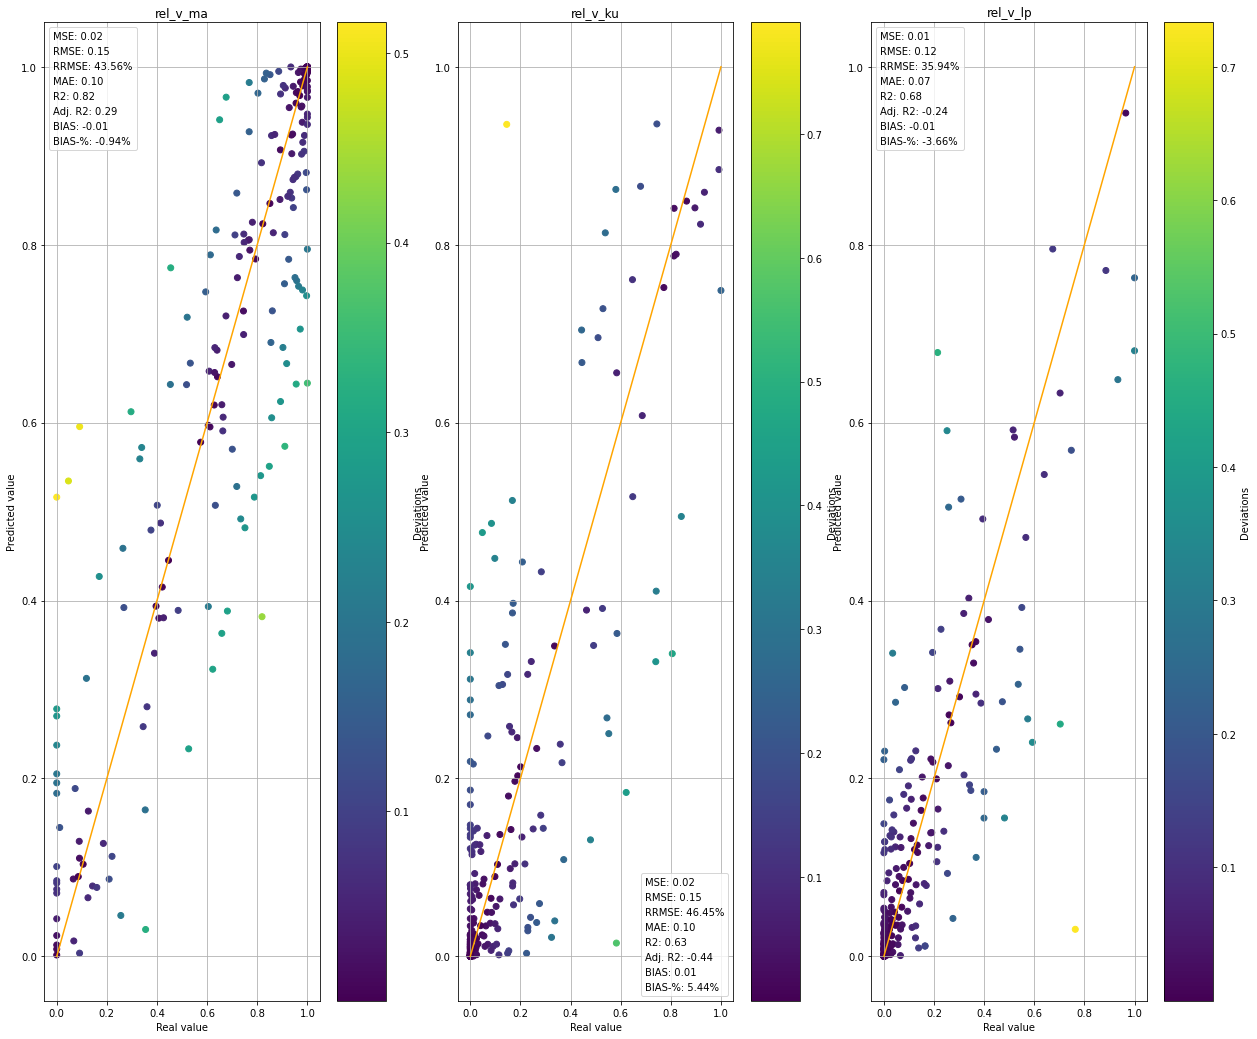

In [83]:
ens_int.plot_results(log_y=False)
plt.show()

Run test set predictions.

In [84]:
test_res = ensemble.validate(dl=test_dls[0])
test_res

AssertionError: ==:
225
675

In [85]:
test_ens_interp = RegressionInterpretation.from_ensemble(ensemble, dl=test_dls[0])

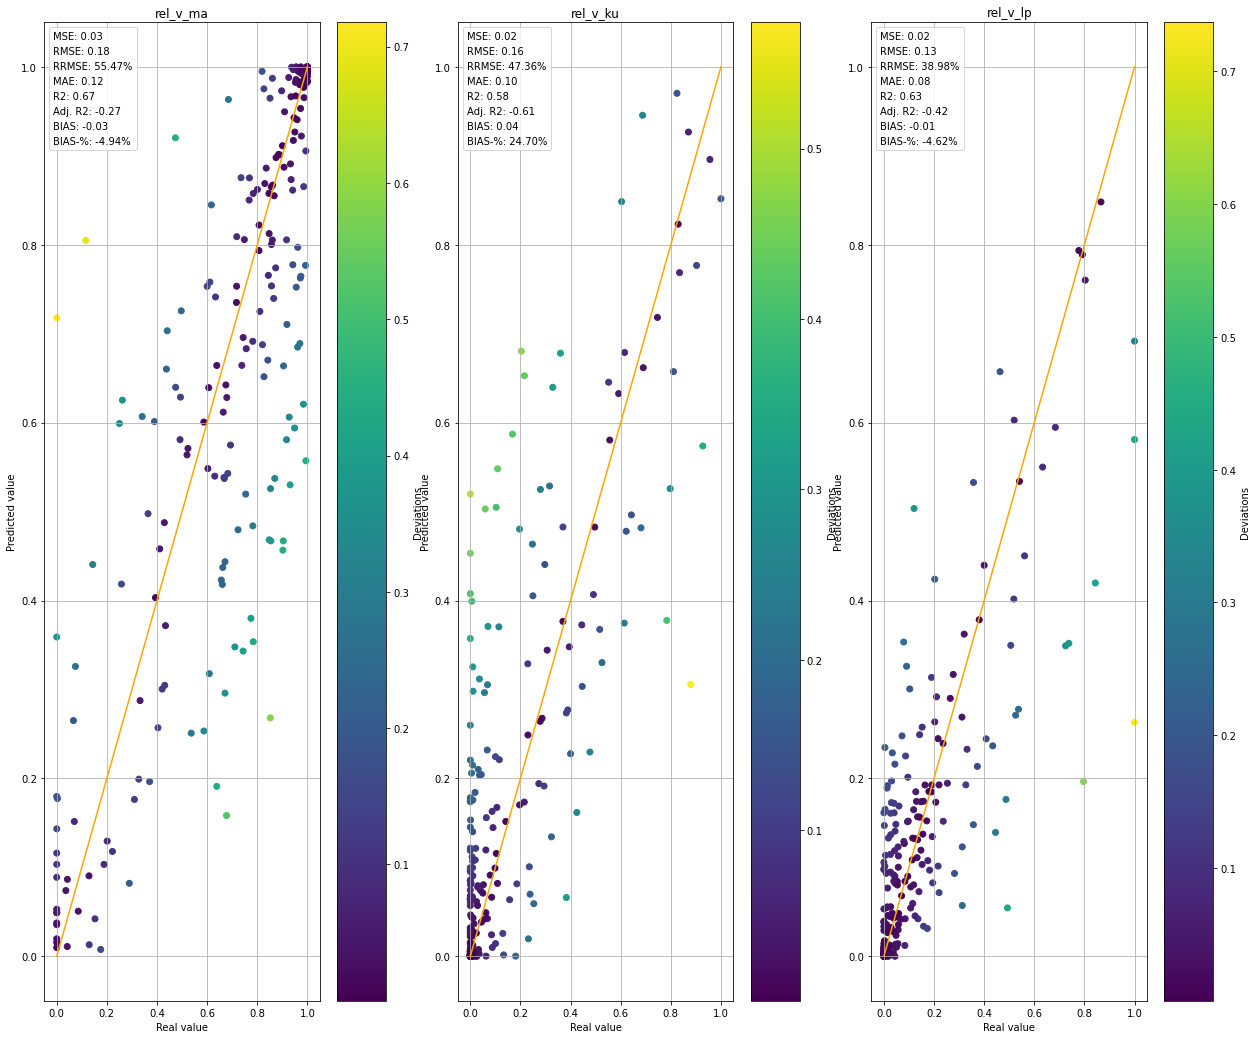

In [86]:
test_ens_interp.plot_results(log_y=False)
plt.show()

In [46]:
ensemble.export(folder='ensemble_h_noint')

In [34]:
loaded_ens = load_ensemble('ensemble')

In [35]:
loaded_ens.validate(dls[1])

,model_identifier,_rmse,_rrmse,_bias,_bias_pct,mae,r2_score
0,ensemble,34.512131,22.890789,4.853094,3.218901,23.012722,0.869123
1,0,36.020157,23.891016,5.776916,3.831643,24.523306,0.857435
2,1,38.956333,25.838488,5.520294,3.661434,26.004436,0.833246
3,2,37.076843,24.591881,5.411808,3.589478,23.871897,0.848948
4,3,36.172024,23.991745,5.350533,3.548837,24.588570,0.856231
5,4,35.007332,23.219242,3.500980,2.322088,24.198902,0.865340
6,5,36.793751,24.404116,4.694864,3.113953,24.732487,0.851246
7,6,38.035831,25.227949,5.096254,3.380182,26.099972,0.841033
8,7,36.272240,24.058214,2.586123,1.715292,24.851715,0.855433
9,8,37.683136,24.994015,6.113510,4.054895,25.995430,0.843968


# Comparison: Random forest

`TabularPandas` makes it simple to use sklearn models with the same data and preprocessing.

In [34]:
from sklearn.ensemble import RandomForestRegressor

Below values for max_features and min_samples_leaf should generally work well.

In [35]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.5, min_samples_leaf=4, oob_score=True)

In [36]:
rf.fit(trainval_tb.train.xs, trainval_tb.train.ys.values.ravel())

RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_estimators=500,
                      oob_score=True)

In [37]:
rf_preds = rf.predict(trainval_tb.valid.xs)

Validation results

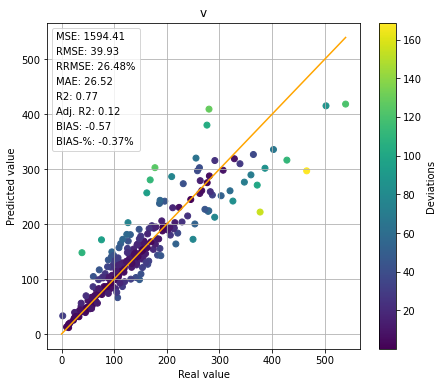

In [38]:
plot_sklearn_regression(rf, trainval_tb.valid.xs, trainval_tb.valid.ys, log_y=False)
plt.show()

Test results

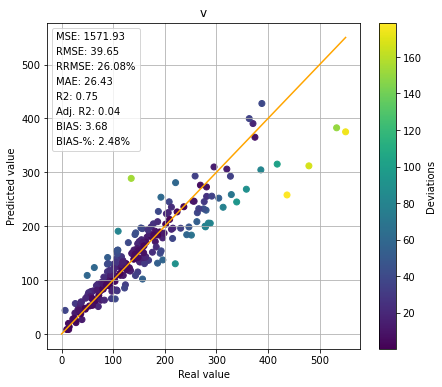

In [39]:
rf_test_preds = rf.predict(test_tb.train.xs)
plot_sklearn_regression(rf, test_tb.train.xs, test_tb.train.ys)
plt.show()